# SPAM or HAM

In [59]:
import os
import math
import nltk
import tqdm
import joblib
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 72
import seaborn as sns
import seaborn.objects as so
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models.fasttext import FastText

from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/mantunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mantunes/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mantunes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mantunes/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/mantunes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [60]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [61]:
def _nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:          
        return None


def _nltk_pos_lemmatizer(lemmatizer, token, tag):
    if tag is None:
        return lemmatizer.lemmatize(token)
    else:        
        return lemmatizer.lemmatize(token, tag)


def text_pre_processing(txt, m=2):
    if txt is not None:
        lemmatizer = WordNetLemmatizer()
        stop_words = set(nltk.corpus.stopwords.words('english'))

        tokens = nltk.word_tokenize(txt)
        tokens = [w for w in tokens if w.isalpha()]
        tokens = nltk.pos_tag(tokens)
        tokens = [(t[0], _nltk_pos_tagger(t[1])) for t in tokens]
        tokens = [_nltk_pos_lemmatizer(lemmatizer, w, t).lower() for w,t in tokens]
        tokens = [w for w in tokens if len(w) > m]
        tokens = [w for w in tokens if w not in stop_words]
    else:
        tokens = []
    return tokens


def div_norm(x):
   norm_value = np.linalg.norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x


def word_vector_to_sentence_vector(sentence:list, model):
    vectors = []
    # for all the tokens in the setence
    for token in sentence:
        if token in model:
            vectors.append(model[token])
    # add the EOS token
    if '\n' in model:
        vectors.append(model['\n'])
    # normalize all the vectors
    vectors = [div_norm(x) for x in vectors]
    return np.mean(vectors, axis=0)

In [62]:
df = pl.read_csv('../../datasets/spam.csv')
df = df.drop_nulls()
df

Target,SMS
str,str
"""ham""","""Go until jurong point, crazy..…"
"""ham""","""Ok lar... Joking wif u oni..."""
"""spam""","""Free entry in 2 a wkly comp to…"
"""ham""","""U dun say so early hor... U c …"
"""ham""","""Nah I don't think he goes to u…"
…,…
"""spam""","""This is the 2nd time we have t…"
"""ham""","""Will �_ b going to esplanade f…"
"""ham""","""Pity, * was in mood for that. …"


In [63]:
dataset = df.rows()
dataset = [(text, label) for (label, text) in dataset]
corpus =  [txt for txt, _ in dataset]
targets = [label for _, label in dataset]

In [64]:
tokens_clean = [text_pre_processing(text) for text in corpus]

In [65]:
text_model = FastText(vector_size=128, window=7, min_count=5, workers=os.cpu_count(), seed=42)
text_model.build_vocab(tokens_clean)

In [66]:
def plot_top_similar(query_word, model, limit=10, color=['maroon', 'blue']):
    embed_dim = model.wv.vectors.shape[1]
    vectors = np.empty((0, embed_dim), dtype='f')
    labels = [query_word]
    types = ['Query Word']
    
    vectors = np.append(vectors, model.wv.__getitem__([query_word]), axis=0)
    
    similar_words = model.wv.most_similar(query_word, topn=limit)
    for word, similarity in similar_words:
        vector = model.wv.__getitem__([word])
        labels.append(word)
        types.append('Similar Words')
        vectors = np.append(vectors, vector, axis=0)
    
    vectors = np.array(vectors)
    vectors_tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=min(30, limit-1)).fit_transform(vectors)
    vectors_tsne_df = pd.DataFrame({
        'X': [x for x in vectors_tsne[:, 0]],
        'Y': [y for y in vectors_tsne[:, 1]],
        'label': labels,
        'Type': types
    })
    _, ax = plt.subplots()
    p = so.Plot(data=vectors_tsne_df, x='X', y='Y', text='label', color='Type').add(so.Dot(marker='o')).add(so.Text(halign='left')).label(legend=None)
    p.on(ax).show()


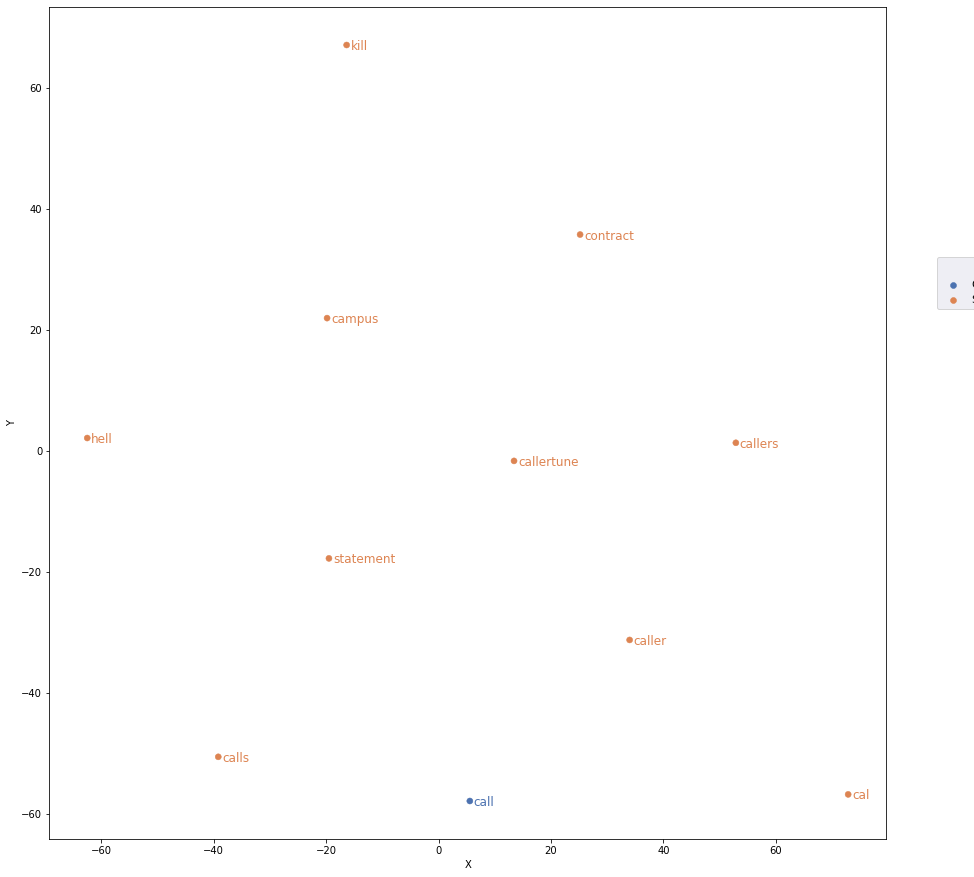

In [67]:
plot_top_similar('call', text_model)

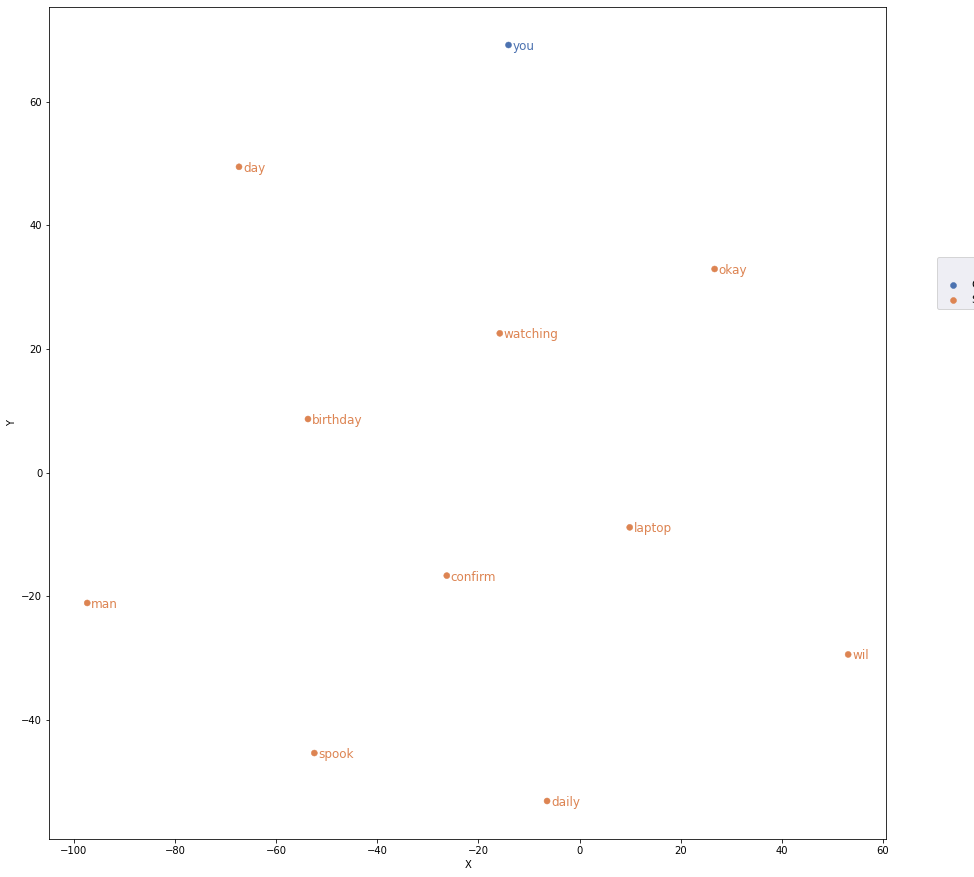

In [68]:
plot_top_similar('you', text_model)

In [69]:
X = np.array([word_vector_to_sentence_vector(sentence, text_model.wv) for sentence in tqdm.tqdm(tokens_clean)])

100%|██████████| 5521/5521 [00:00<00:00, 11404.91it/s]


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, stratify=targets, test_size=0.2, random_state=42)

In [71]:
print(f'Training Data : {len(X_train)}')
print(f'Testing Data  : {len(X_test)}')

# define the list of classifiers
clfs = [
    ('LR', LogisticRegression(random_state=42, max_iter=600)),
    ('KNN', KNeighborsClassifier(n_neighbors=1)),
    ('NB', GaussianNB()),
    ('RFC', RandomForestClassifier(random_state=42)),
    ('MLP', MLPClassifier(random_state=42, learning_rate='adaptive', max_iter=1000))
]

# whenever possible used joblib to speed-up the training
with joblib.parallel_backend('loky', n_jobs=-1):
    for label, clf in clfs:
        # train the model
        clf.fit(X_train, y_train)

        # generate predictions
        predictions = clf.predict(X_test)

        # compute the performance metrics
        mcc = matthews_corrcoef(y_test, predictions)
        acc = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='weighted')
        print(f'{label:3} {acc:.2f} {f1:.2f} {mcc:.2f}')

Training Data : 4416
Testing Data  : 1105
LR  0.90 0.87 0.45
KNN 0.94 0.94 0.76
NB  0.74 0.78 0.43
RFC 0.93 0.92 0.69
MLP 0.96 0.96 0.82
